In [1]:
"""
===========================================================
Using PyPARRM to filter out stimulation artefacts from data
===========================================================

This example demonstrates how the PARRM algorithm :footcite:`DastinEtAl2021`
can be used to identify and remove stimulation artefacts from
electrophysiological data in the PyPARRM package.
"""

import numpy as np
from matplotlib import pyplot as plt

import sys
import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

sys.path.append('../../../../existing_SAC/PARRM/PyPARRM-main/src/pyparrm')

from parrm import PARRM
from _utils._power import compute_psd

# fpath='../../../../data/synthetic_data/'
fpath = "../../../../data/synthetic_data/evaluation_data/"

Contaminated = np.load(fpath + "contaminated_by_realistic" + ".npy")
Clean = np.load(fpath + "clean_data" + ".npy")
Contaminated = Contaminated[0:10]
Clean = Clean[0:10]

In [2]:
fs = 2000  # Hz
artefact_freq = 125  # Hz

winTime = 0.99
skipTime = winTime / 30
perDist = 0.01

winSize = int(fs*winTime)
skipSize = int(fs*skipTime)
winDir = "both"

print(
    f"`data` has shape: ({Contaminated.shape[0]} channel, "
    f"{Contaminated.shape[1]} timepoints)\n"
    f"`data` duration: {Contaminated.shape[1] / fs :.2f} seconds"
)

`data` has shape: (10 channel, 4000 timepoints)
`data` duration: 2.00 seconds


In [3]:
# parrm = PARRM(
#     data=Contaminated,
#     sampling_freq=fs,
#     artefact_freq=artefact_freq,
#     verbose=False,  # silenced to reduce pqdm output clutter
# )
# parrm.find_period()

# print(f"Estimated artefact period: {parrm.period :.4f}")

# parrm.create_filter(
#     filter_half_width=winSize,
#     omit_n_samples=skipSize,
#     filter_direction="both",
#     period_half_width=perDist,
# )
# filtered_data = parrm.filter_data()  # other data to filter can be given here


Estimated artefact period: 16.0001


In [4]:
## 기존 ##
parrmed = []

for i in range(Contaminated.shape[0]):
    parrm = PARRM(
        data=Contaminated,
        sampling_freq=fs,
        artefact_freq=artefact_freq,
        verbose=False,  # silenced to reduce pqdm output clutter
    )

    parrm.find_period()

    print(f"Sample : {i} | Estimated artefact period: {parrm.period :.4f}")

    parrm.create_filter(
        filter_half_width=winSize,
        omit_n_samples=skipSize,
        filter_direction=winDir,
        period_half_width=perDist,
    )
    parrmed_data = parrm.filter_data()  # other data to filter can be given here
    parrmed.append(parrmed_data)


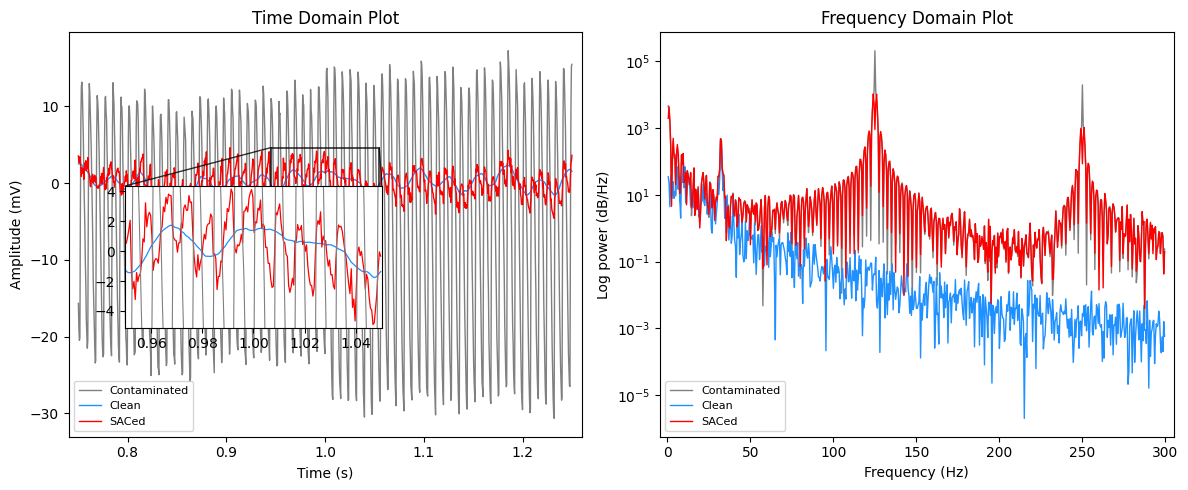

< MSE >
Time Domain MSE: 31.652266778581158 ± 4.647163647610244
Frequency Domain MSE: 553544.9337375474 ± 262696.35130134417
Time + Frequency MSE: 7480.058768430066 ± 1701.7234624789658


In [5]:
# save_path = '../../../../result/paper/'
# save_title = 'PARRM'
Result_Plot(Contaminated, parrmed_data, Clean)
# Result_Plot_paper(Contaminated, parrmed_data, Clean, save_path, save_title)

C:\Users\stell\AppData\Local\Temp\ipykernel_21040\2613125540.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


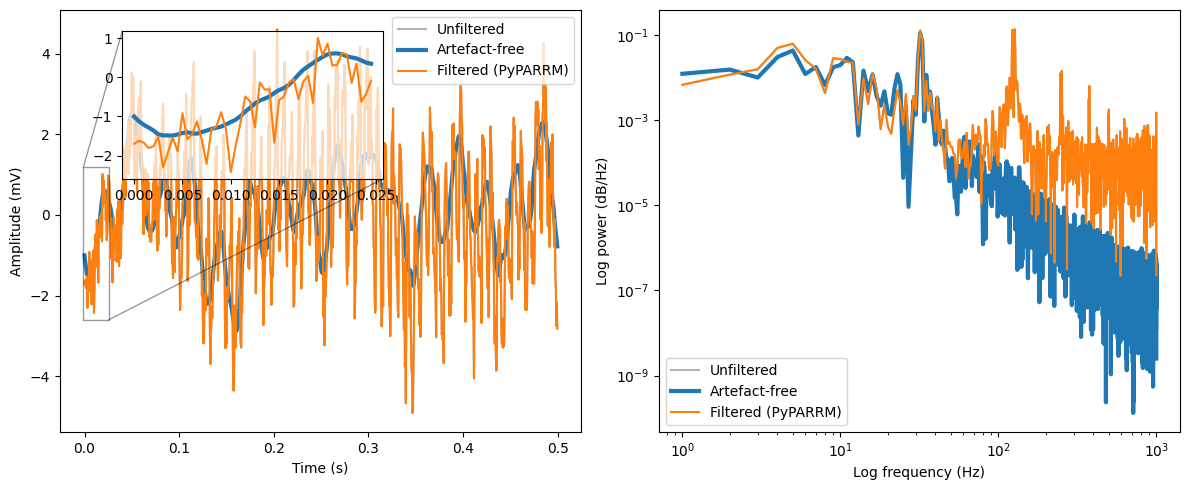

In [12]:
sampling_freq = fs

# comparison to true artefact-free data
artefact_free = Clean
data = filtered_data
start = int(0.7 * fs)# same start time as MATLAB example
end =  int(1.2 * fs) # same end time as MATLAB example
times = np.arange(end - start) / sampling_freq

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
inset_axis = axes[0].inset_axes((0.12, 0.6, 0.5, 0.35))

# main timeseries plot
axes[0].plot(
    times, data[0, start:end], color="black", alpha=0.3, label="Unfiltered"
)
axes[0].plot(
    times, artefact_free[0, start:end], linewidth=3, label="Artefact-free"
)
axes[0].plot(times, filtered_data[0, start:end], label="Filtered (PyPARRM)")
axes[0].legend()
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude (mV)")

# timeseries inset plot
inset_axis.plot(times[:50], artefact_free[0, start : start + 50], linewidth=3)
inset_axis.plot(times[:50], filtered_data[0, start : start + 50])
axes[0].indicate_inset_zoom(inset_axis, edgecolor="black", alpha=0.4)
inset_axis.patch.set_alpha(0.7)

# power spectral density plot
n_freqs = sampling_freq / 2
psd_freqs, psd_raw = compute_psd(
    data[0, start:end], sampling_freq, int(n_freqs * 2)
)
_, psd_filtered = compute_psd(
    filtered_data[0, start:end], sampling_freq, int(n_freqs * 2)
)
_, psd_artefact_free = compute_psd(
    artefact_free[0, start:end], sampling_freq, int(n_freqs * 2)
)

axes[1].loglog(
    psd_freqs, psd_raw, color="black", alpha=0.3, label="Unfiltered"
)
axes[1].loglog(
    psd_freqs, psd_artefact_free, linewidth=3, label="Artefact-free"
)
axes[1].loglog(psd_freqs, psd_filtered, label="Filtered (PyPARRM)")
axes[1].legend()
axes[1].set_xlabel("Log frequency (Hz)")
axes[1].set_ylabel("Log power (dB/Hz)")

fig.tight_layout()
fig.show()